# Car Insurance Policy Data

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, StandardScaler, minmax_scale

%matplotlib inline
pd.options.display.max_rows = 100
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [72]:
def col_rename(df, dict_rules, ip=True):
    ''' rename columns in data frame using a dictionary of rules  '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(dict_rules,dict):
        z = df.rename(columns = dict_rules, inplace=ip)
    else:
        raise TypeError
    return z
#
def print_unique(df,col):
    ''' gives a list of unique values in a field '''
    if isinstance(df,pd.core.frame.DataFrame) and isinstance(col,pd.core.frame.Series):
        z = df[col].unique()
    else:
        raise TypeError
    return z
#
def lower_case_column_names(df):
    ''' make columns lower case '''
    if isinstance(df,pd.core.frame.DataFrame):
        df.columns= [i.lower() for i in df.columns]
        df.columns = df.columns.str.replace(' ', '_')
    else: 
        raise TypeError
    return df

def Remove_Outlier_Indices(df):
    """ returns a df of boolean values to used to index a trimmed table in the 1.5*IQR range"""
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5*IQR)) |(df > (Q3 + 1.5*IQR)))
    return trueList

##  Analysis
CONTENTS: 
  -  PDFs/Histograms
  -  Correlations
  -  Gaussianity determination
  -  Frequency counts and aggregations
  -  Pearson correlation heat map


### Read the data

In [73]:
c_df = pd.read_csv('Data/Data_Marketing_Customer_Analysis_Round3.csv') # fairly clean data (no nulls)
c_df.select_dtypes(include=np.number).columns.tolist() # fields


['Unnamed: 0',
 'customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies',
 'total_claim_amount']

In [74]:
c_df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)
c_df.drop(labels=['effective_to_date'],axis=1,inplace=True)
# split cols
numericals_df   = c_df.select_dtypes(include=np.number)
categoricals_df = c_df.select_dtypes(include=object)

    #### HEATMAP

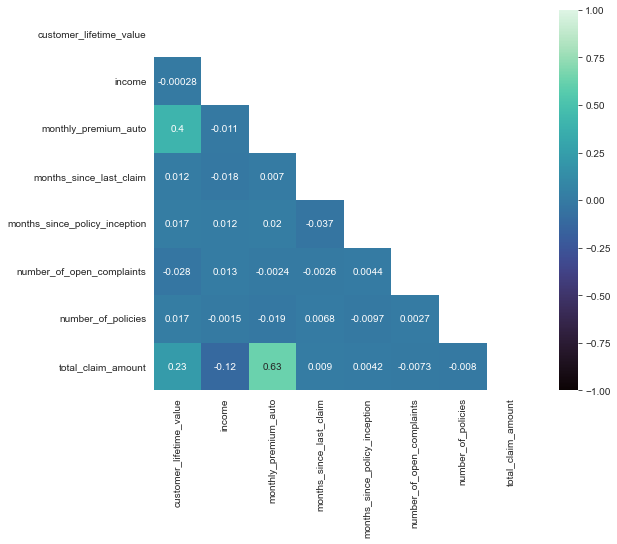

In [5]:
corr_ij = numericals_df.corr()
mask = np.zeros_like(corr_ij)
mask[np.triu_indices_from(mask)] = True
color_map = sns.color_palette("mako", as_cmap=True)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(9, 7))
    ax = sns.heatmap(corr_ij, mask=mask,cmap=color_map, vmin=-1,vmax=1,annot=True, square=True)

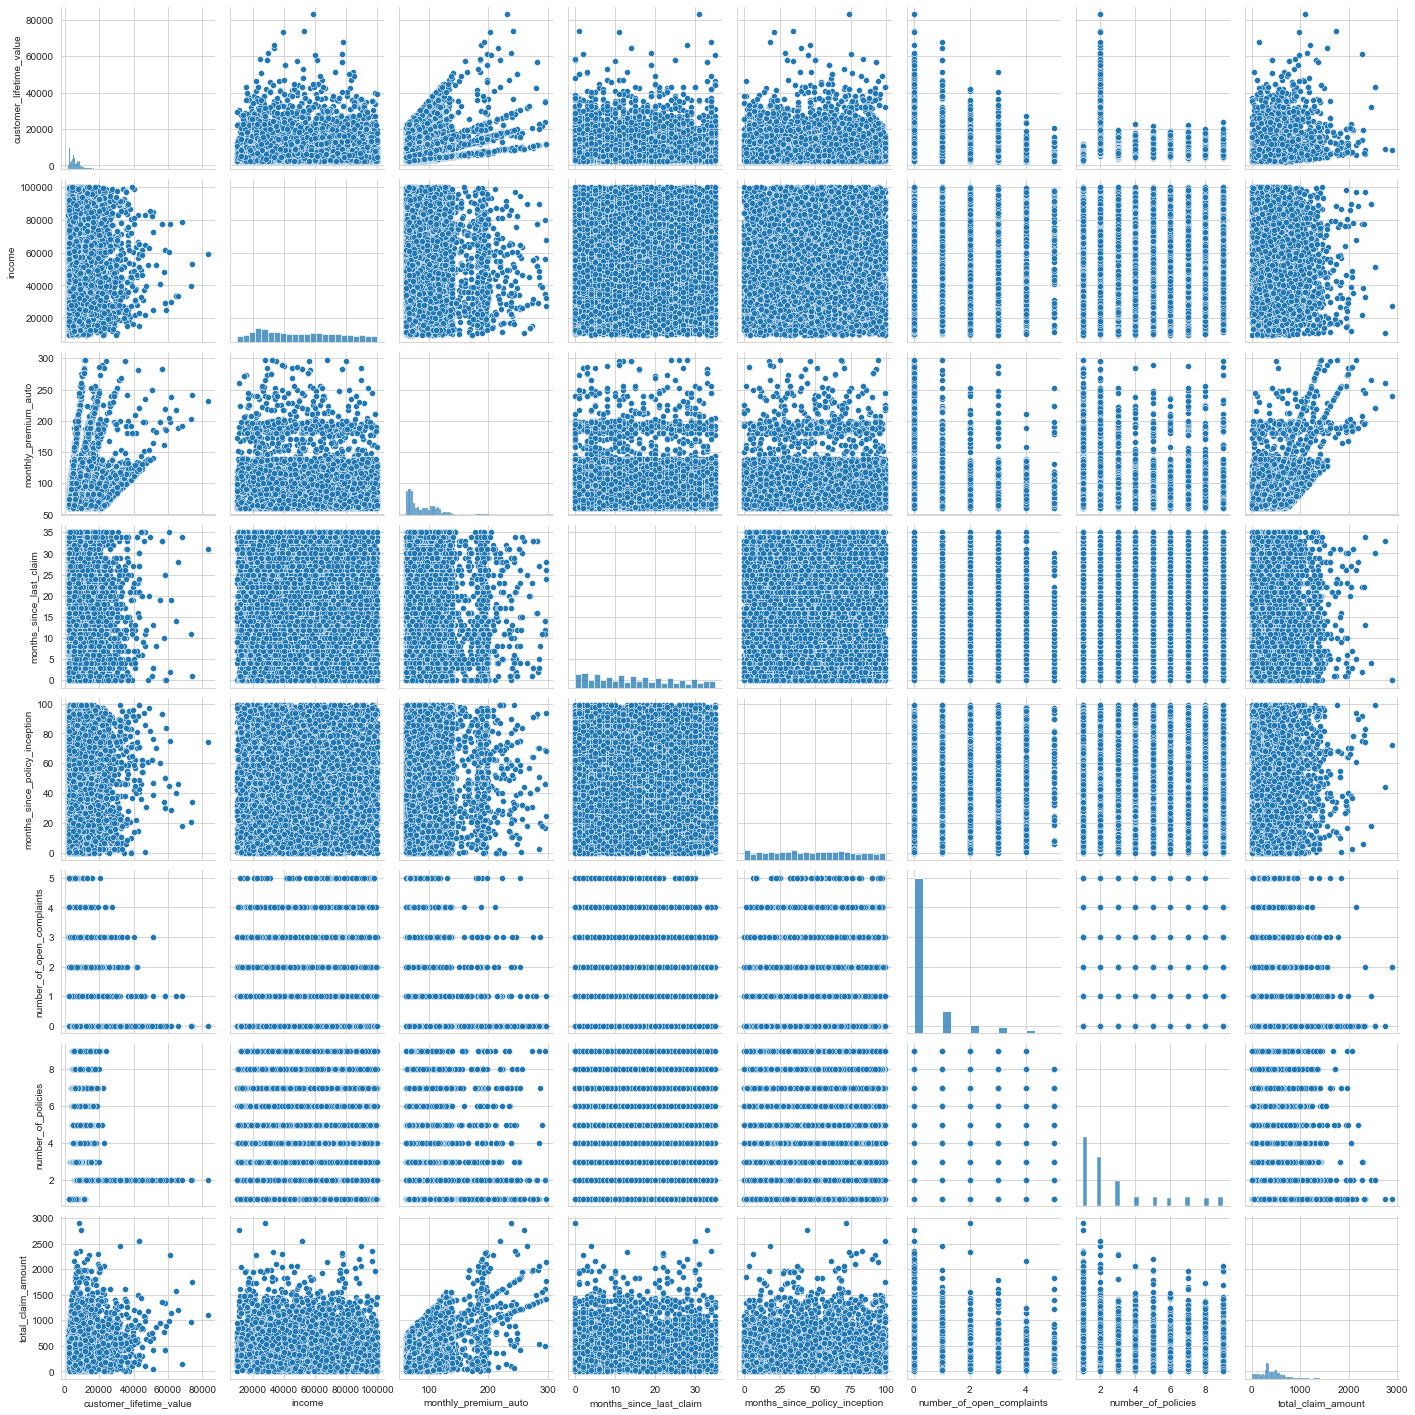

In [6]:
sns.pairplot(numericals_df)

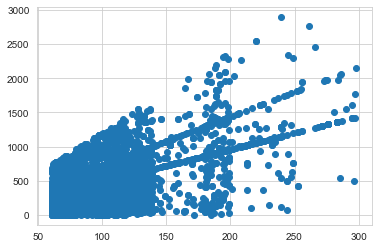

In [7]:
plt.scatter(x=numericals_df['monthly_premium_auto'], y=numericals_df['total_claim_amount'])
plt.show()

In [8]:
corr_thresh    =  0.9
corr_abs       = corr_ij.abs()
upper_triangle = corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(bool))
[column for column in upper_triangle.columns if any(upper_triangle[column] > corr_thresh)]

[]

### trans of cats

In [9]:
categoricals_df.columns


Index(['region', 'response', 'coverage', 'education', 'month',
       'employment_status', 'gender', 'location_code', 'marital_status',
       'policy_type', 'policy', 'renew_offer_type', 'sales_channel',
       'vehicle_class', 'vehicle_size'],
      dtype='object')

In [10]:
encoded_fields = ['region', 'response', 'month', 'gender', 'location_code',
       'marital_status', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel']
cats_oh_df = pd.get_dummies(categoricals_df, columns=encoded_fields, prefix= "oh") # one-hot
cats_oh_df.head()

,coverage,education,employment_status,vehicle_class,vehicle_size,oh_central,oh_east,oh_north west,oh_west region,oh_no,...,oh_special l2,oh_special l3,oh_offer1,oh_offer2,oh_offer3,oh_offer4,oh_agent,oh_branch,oh_call center,oh_web
0,basic,college,employed,four-door car,medsize,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,basic,college,unemployed,four-door car,medsize,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
2,basic,bachelor,employed,suv,medsize,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,extended,college,employed,four-door car,medsize,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,premium,bachelor,medical leave,four-door car,medsize,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0


In [68]:
fields_to_label = ["employment_status", "education", "vehicle_size", "vehicle_class", "coverage"]
label_rules_unordered = [ {str(x): dict(zip(categoricals_df[x].unique(), np.arange(1,len(x)+1,1)))} for x in categoricals_df[fields_to_label].columns] # random assignment
label_rules_unordered[0:]

[{'employment_status': {'employed': 1,
   'unemployed': 2,
   'medical leave': 3,
   'disabled': 4,
   'retired': 5}},
 {'education': {'college': 1,
   'bachelor': 2,
   'high school or below': 3,
   'doctor': 4,
   'master': 5}},
 {'vehicle_size': {'medsize': 1, 'small': 2, 'large': 3}},
 {'vehicle_class': {'four-door car': 1,
   'suv': 2,
   'two-door car': 3,
   'sports car': 4,
   'luxury car': 5,
   'luxury suv': 6}},
 {'coverage': {'basic': 1, 'extended': 2, 'premium': 3}}]

In [69]:
# label encoding
for x in cats_oh_df[fields_to_label].columns:
    rep_rule_x = dict(zip(cats_oh_df[x].unique(), np.arange(1,len(x)+1,1)))
    cats_oh_df[x] = cats_oh_df[x].replace(rep_rule_x)
cats_oh_df

,coverage,education,employment_status,vehicle_class,vehicle_size,oh_central,oh_east,oh_north west,oh_west region,oh_no,...,oh_special l2,oh_special l3,oh_offer1,oh_offer2,oh_offer3,oh_offer4,oh_agent,oh_branch,oh_call center,oh_web
0,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,1,1,2,1,1,0,0,0,1,1,...,0,0,0,0,0,1,0,0,1,0
2,1,2,1,2,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,2,1,1,1,1,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,3,2,3,1,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,3,2,2,5,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
10685,1,1,1,1,1,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0
10686,2,2,1,6,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
10687,3,1,1,2,1,0,0,0,1,1,...,0,0,1,0,0,0,0,1,0,0


###  trans of nums

array([[<AxesSubplot:title={'center':'customer_lifetime_value'}>,
        <AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'monthly_premium_auto'}>],
       [<AxesSubplot:title={'center':'months_since_last_claim'}>,
        <AxesSubplot:title={'center':'months_since_policy_inception'}>,
        <AxesSubplot:title={'center':'number_of_open_complaints'}>],
       [<AxesSubplot:title={'center':'number_of_policies'}>,
        <AxesSubplot:title={'center':'total_claim_amount'}>,
        <AxesSubplot:>]], dtype=object)

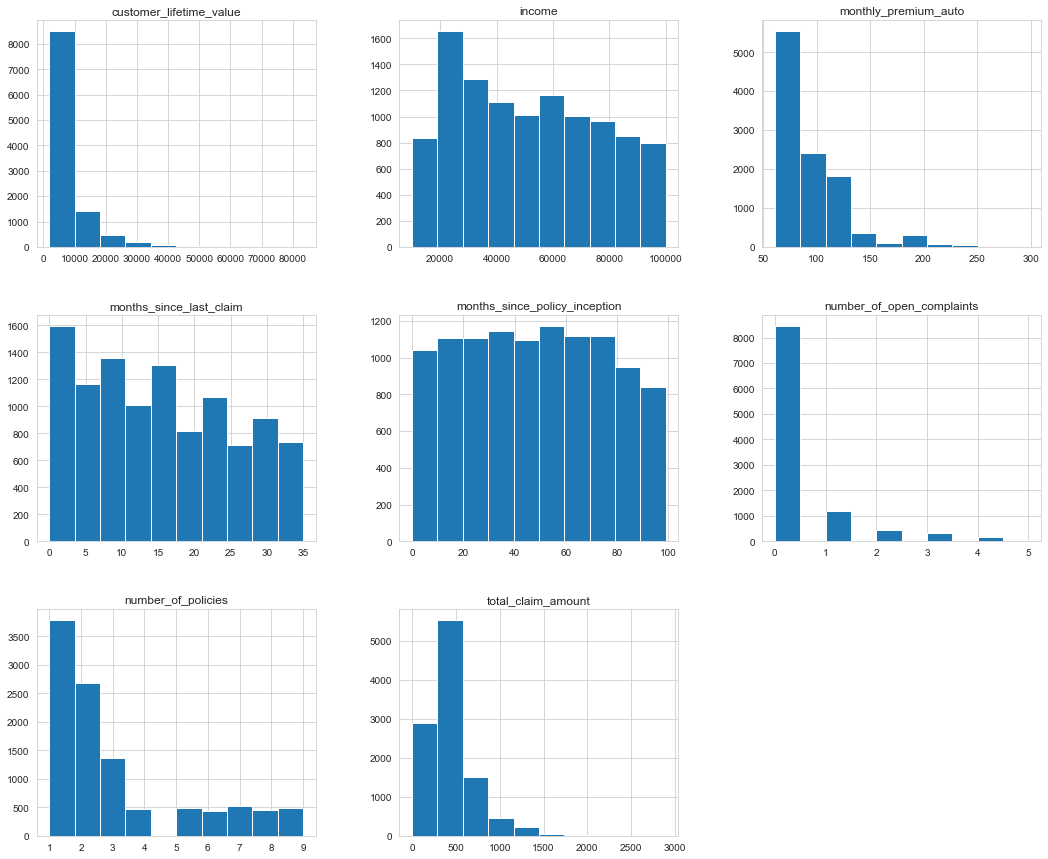

In [14]:
numericals_df.hist(figsize=(18,15)) # make histograms

<i> the number_of_open_complaints and number_of_policies fields are discrete so we remove them below

In [15]:
n_data = [x for x in numericals_df.columns] # list of columns
n_data

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies',
 'total_claim_amount']

In [16]:
# remove the discrete fields
n_data.remove('number_of_open_complaints')
n_data.remove('number_of_policies')

#### Distributions 

<AxesSubplot:xlabel='customer_lifetime_value', ylabel='Density'>

<AxesSubplot:xlabel='income', ylabel='Density'>

<AxesSubplot:xlabel='monthly_premium_auto', ylabel='Density'>

<AxesSubplot:xlabel='months_since_last_claim', ylabel='Density'>

<AxesSubplot:xlabel='months_since_policy_inception', ylabel='Density'>

<AxesSubplot:xlabel='total_claim_amount', ylabel='Density'>

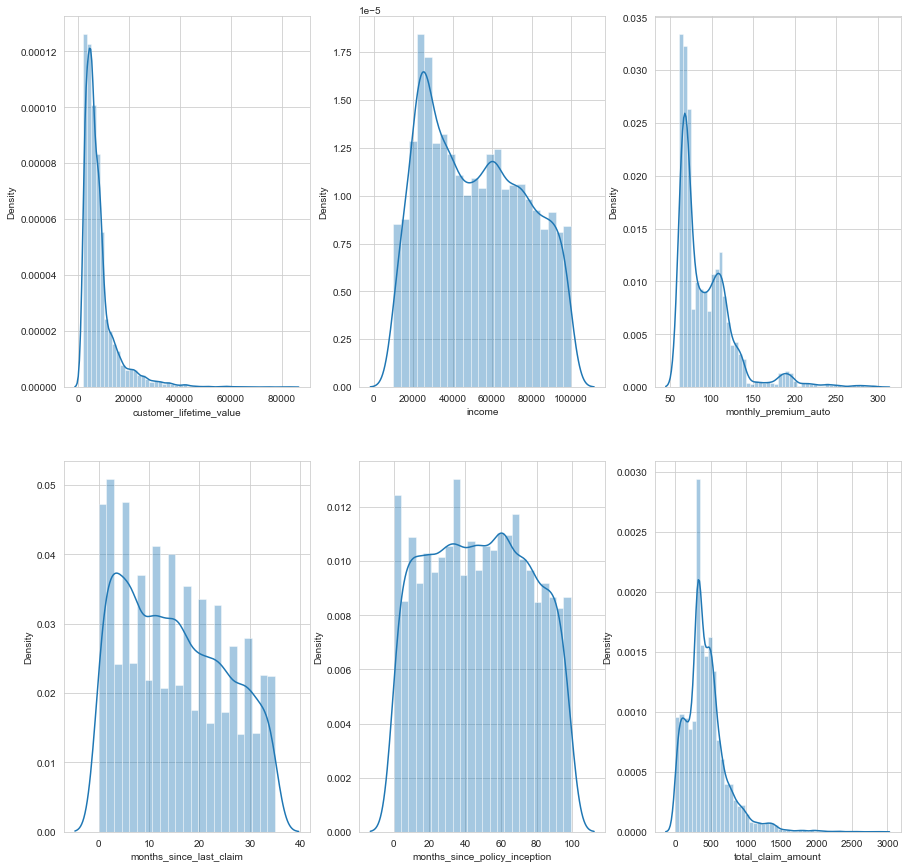

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=2,figsize=(15,15))
# generate canvas of plots
for i, ax in zip(range(6), axes.flat):
    sns.distplot(c_df[n_data[i]], ax=ax, kde=True)
plt.show()

In [76]:
numericals_df.customer_lifetime_value.max()


83325

<AxesSubplot:ylabel='Density'>

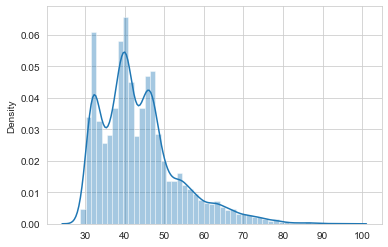

In [18]:
cust_lifetime_boxcox = boxcox(numericals_df['customer_lifetime_value'],lmbda=.3)
sns.distplot(cust_lifetime_boxcox)

<AxesSubplot:ylabel='Density'>

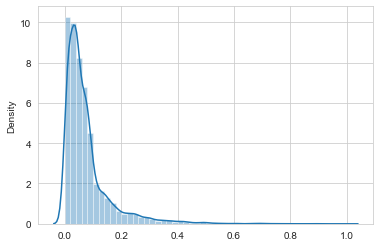

In [19]:
cust_lifetime_minmax = minmax_scale(numericals_df['customer_lifetime_value'])
sns.distplot(cust_lifetime_minmax)

In [33]:
from scipy.stats import shapiro

In [20]:
pt_types = ['yeo-johnson', 'box-cox']

In [21]:
# standardized power transform (zero mean and unit variance)

power = PowerTransformer(method='yeo-johnson', standardize=True)

In [34]:
clv = numericals_df['customer_lifetime_value'].to_numpy().reshape(-1,1)

In [35]:
clv.mean()

8011.906726541304

In [36]:
cust_lifetime_yeo = power.fit_transform(clv)

In [37]:
cust_lifetime_yeo.mean().round(10)

0.0

<AxesSubplot:ylabel='Density'>

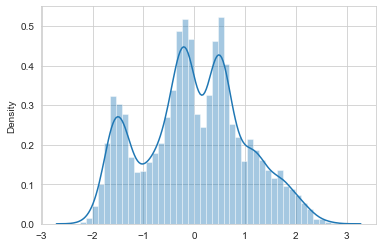

In [26]:
sns.distplot(cust_lifetime_yeo)

#### Remove outliers (numerical data outsider IQR)

In [40]:
# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(numericals_df)
# Non-Outlier Subset of the Given Datasetnu
numericals_df = numericals_df[nonOutlierList.all(1)]


In [41]:
numericals_df

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
1,2228,26794,64,3,26,0,1,744
2,14947,22139,100,34,31,0,2,480
5,4745,50549,61,2,73,0,7,292
7,4956,87197,63,35,45,0,3,247
8,5989,66839,154,33,24,0,1,739
...,...,...,...,...,...,...,...,...
10674,6232,28334,83,3,44,0,7,537
10676,9075,37722,116,8,23,0,8,158
10677,5807,62447,74,9,2,0,7,133
10680,4547,33531,116,11,15,0,1,801


#### Test for normality
[Shapiro-Wilk statistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [63]:
for x in numericals_df.columns:
    #shapiro(numericals_df[col])
    print("W-statisic({}) : {}.".format(x, shapiro(numericals_df[x])))

W-statisic(customer_lifetime_value) : ShapiroResult(statistic=0.9106581807136536, pvalue=0.0).
W-statisic(income) : ShapiroResult(statistic=0.9543147683143616, pvalue=6.150298959921622e-42).
W-statisic(monthly_premium_auto) : ShapiroResult(statistic=0.8949412703514099, pvalue=0.0).
W-statisic(months_since_last_claim) : ShapiroResult(statistic=0.9513199329376221, pvalue=6.165713243029195e-43).
W-statisic(months_since_policy_inception) : ShapiroResult(statistic=0.9595323204994202, pvalue=4.60234059832057e-40).
W-statisic(number_of_open_complaints) : ShapiroResult(statistic=1.0, pvalue=1.0).
W-statisic(number_of_policies) : ShapiroResult(statistic=0.787102222442627, pvalue=0.0).
W-statisic(total_claim_amount) : ShapiroResult(statistic=0.9836857914924622, pvalue=1.9275900959992977e-27).


/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1758: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [64]:
for x in numericals_df.columns:
    print("W-statisic({}) : {}.".format(x, shapiro(power.fit_transform(numericals_df[x].to_numpy().reshape(-1,1)))))

W-statisic(customer_lifetime_value) : ShapiroResult(statistic=0.9699847102165222, pvalue=1.2308754597944386e-35).
W-statisic(income) : ShapiroResult(statistic=0.9623753428459167, pvalue=5.851065685849701e-39).
W-statisic(monthly_premium_auto) : ShapiroResult(statistic=0.9297336339950562, pvalue=0.0).
W-statisic(months_since_last_claim) : ShapiroResult(statistic=0.9646956324577332, pvalue=5.235853621057176e-38).
W-statisic(months_since_policy_inception) : ShapiroResult(statistic=0.9616433382034302, pvalue=2.9971041619902404e-39).
W-statisic(number_of_open_complaints) : ShapiroResult(statistic=1.0, pvalue=1.0).
W-statisic(number_of_policies) : ShapiroResult(statistic=0.8377010822296143, pvalue=0.0).
W-statisic(total_claim_amount) : ShapiroResult(statistic=0.9882237911224365, pvalue=1.6037427029451008e-23).


/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/antares/.pyenv/versions/m